In [3]:
#pip install dmba

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage

import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

# To filter the warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [8]:
lung = pd.read_csv('LungDisease.csv')
lung.head()

,PEFR,Exposure
0,390,0
1,410,0
2,430,0
3,460,0
4,420,1


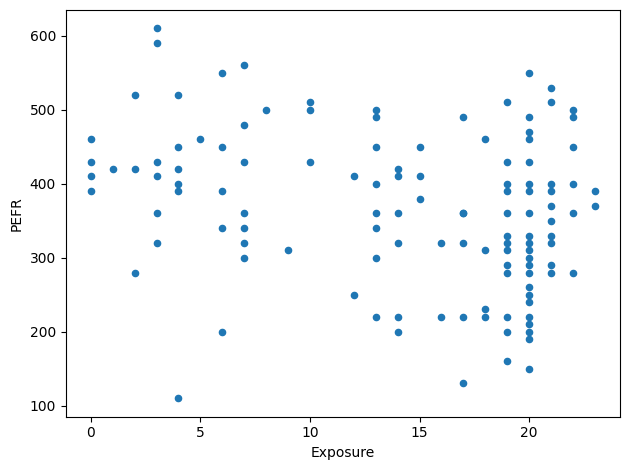

In [9]:
lung.plot.scatter(x="Exposure", y="PEFR")
plt.tight_layout()
plt.show()


In [14]:
predictors = ['Exposure']
outcome = 'PEFR'

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f"Intercept: {model.intercept_:.3f}")
print(f"Coefficient: {model.coef_[0]:.3f}")

Intercept: 424.583
Coefficient: -4.185


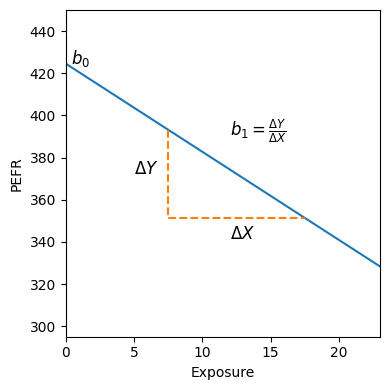

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
ax.set_xlim(0,23)
ax.set_ylim(295,450)
ax.set_xlabel("Exposure")
ax.set_ylabel("PEFR")
ax.plot((0,23), model.predict(pd.DataFrame({'Exposure':[0,23]})))
ax.text(0.4, model.intercept_, r'$b_0$', size='larger')

x=pd.DataFrame({"Exposure":[7.5,17.5]})
y=model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), '--')
ax.text(5, np.mean(y), r'$\Delta Y$', size='larger')
ax.text(12, y[1] - 10, r'$\Delta X$', size='larger')
ax.text(12, 390, r'$b_1 = \frac{\Delta Y}{\Delta X}$', size='larger')

plt.tight_layout()
plt.show()

## Fitted Values and Residuals

In [18]:
fitted = model.predict(lung[predictors])
residuals = lung[outcome]-fitted

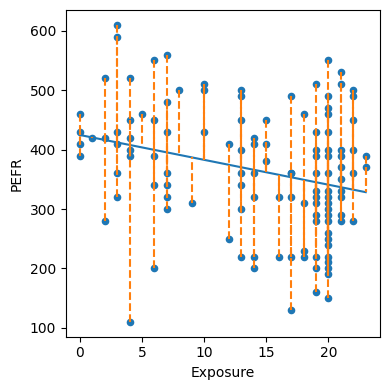

In [19]:
ax = lung.plot.scatter(x='Exposure', y='PEFR', figsize=(4,4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted):
    ax.plot((x,x), (yactual,yfitted), '--', color='C1')
    
plt.tight_layout()
plt.show()

## Multiple linear regression

In [24]:
subset = ['AdjSalePrice','SqFtTotLiving','SqFtLot','Bathrooms','Bedrooms','BldgGrade']
house = pd.read_csv('house_sales.csv', sep='\t')
#house.head()
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [30]:
predictors =['SqFtTotLiving','SqFtLot','Bathrooms','Bedrooms','BldgGrade'] # x values
outcome = 'AdjSalePrice' # y value

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f"Intercept: {house_lm.intercept_:.3f}")
print(f"Coefficients:")
for name, coef in zip(predictors, house_lm.coef_):
    print(f" {name}: {coef:.4f}")

Intercept: -521871.368
Coefficients:
 SqFtTotLiving: 228.8306
 SqFtLot: -0.0605
 Bathrooms: -19442.8404
 Bedrooms: -47769.9552
 BldgGrade: 106106.9631


## Assessing the Model

In [31]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f"RMSE: {RMSE:.0f}")
print(f"r2: {r2:.4f}")

RMSE: 261220
r2: 0.5406


In [34]:
model = sm.OLS(house[outcome],house[predictors].assign(const=1)) # a different way to assign the constant
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:02:00   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694

## Model Selection and Stepwise Regression

In [35]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True, dtype=int) # a little different here
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full=sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:11:41   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

In [38]:
y = house[outcome]

def train_model(variables):
    if len(variables)==0:
        return None
    model = LinearRegression()
    model.fit(X[variables],y)
    return model

def score_model(model, variables):
    if len(variables)==0:
        return AIC_score(y, [y.mean()]*len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]),model)

best_model, best_variables = stepwise_selection(
    X.columns,
    train_model,
    score_model,
    verbose=True)

print(f"Intercept: {best_model.intercept_:.3f}")
print(f"Coefficients:")
for name, coef in zip(best_variables, best_model.coef_):
    print(f" {name}: {coef}")

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None
Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201554
 BldgGrade: 137159.56022620035
 YrBuilt: -3565.4249392493266
 Bedrooms: -51947.38367361375
 Bathrooms: 42396.164527718895
 PropertyType_Townhouse: 84479.16203300108
 SqFtFinBasement: 7.046974967571554
 PropertyType_Single Family: 22912.05518701775


## Weighted regression

In [39]:
house["Year"] = [int(date.split("-")[0]) for date in house["DocumentDate"]]
house["Year"] = house.DocumentDate.apply(lambda d: int(d.split("-")[0]))
house["Weight"] = house["Year"] - 2005

In [40]:
house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction,Year,Weight
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,7,1991,0,0,70000,229000,98002,False,2014,9
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,10,2005,0,0,203000,590000,98166,True,2006,1
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,8,1947,0,0,183000,275000,98166,False,2007,2
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,7,1966,0,0,104000,229000,98168,False,2008,3
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,7,1948,0,0,104000,205000,98168,False,2013,8


In [41]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house["Weight"])

pd.concat([
    pd.DataFrame({
        'predictor': predictors,
        'house_lm': house_lm.coef_,
        'house_wt': house_wt.coef_,    
    }),
    pd.DataFrame({
        'predictor': ['intercept'],
        'house_lm': house_lm.intercept_,
        'house_wt': house_wt.intercept_,    
    })
])

,predictor,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
0,intercept,-521871.368188,-584189.329446


In [43]:
residuals = pd.DataFrame({
    "abs_residual_lm": np.abs(house_lm.predict(house[predictors])-house[outcome]),
    "abs_residual_wt": np.abs(house_wt.predict(house[predictors])-house[outcome]),
    "Year": house["Year"]
})

print(residuals.head())

pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])] 
              for year, group in residuals.groupby('Year')),
             columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])

   abs_residual_lm  abs_residual_wt  Year
1    123750.814194    107108.553965  2014
2     59145.413089     96191.882094  2006
3    190108.725716    187004.492880  2007
4    198788.774412    196132.996857  2008
5     91774.996129     84277.577512  2013


,Year,mean abs_residual_lm,mean abs_residual_wt
0,2006,140540.303585,146557.454636
1,2007,147747.577959,152848.523235
2,2008,142086.905943,146360.411668
3,2009,147016.720883,151182.924825
4,2010,163267.674885,166364.476152
5,2011,169937.385744,172950.876028
6,2012,169506.670053,171874.424266
7,2013,203659.777510,206242.199403
8,2014,184452.840665,186668.573750
9,2015,172323.435147,169842.742053


# Factor variables in regression
## Dummy Variables Representation

In [44]:
print(house["PropertyType"].head())

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object


In [45]:
print(pd.get_dummies(house["PropertyType"]).head(6))

   Multiplex  Single Family  Townhouse
1       True          False      False
2      False           True      False
3      False           True      False
4      False           True      False
5      False           True      False
6      False          False       True


In [47]:
print(pd.get_dummies(house["PropertyType"], drop_first=True).head(6))

   Single Family  Townhouse
1          False      False
2           True      False
3           True      False
4           True      False
5           True      False
6          False       True


In [50]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house["PropertyType"], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f'Intercept: {house_lm_factor.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f' {name}: {coef}')

Intercept: 548084.716
Coefficients:
 Single Family: 27323.601083372134
 Townhouse: -103564.76975447712


In [49]:
X

,Single Family,Townhouse
1,False,False
2,True,False
3,True,False
4,True,False
5,True,False
...,...,...
27057,True,False
27058,True,False
27061,True,False
27062,True,False


## Factor Variables with many levels

In [52]:
print(pd.DataFrame(house['ZipCode'].value_counts()).T)

ZipCode  98038  98103  98042  98115  98117  98052  98034  98033  98059  98074  \
count      788    671    641    620    619    614    575    517    513    502   

ZipCode  ...  98051  98024  98354  98050  98057  98288  98224  98068  98113  \
count    ...     32     31      9      7      4      4      3      1      1   

ZipCode  98043  
count        1  

[1 rows x 80 columns]


In [54]:
house = pd.read_csv('house_sales.csv', sep="\t")
house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bathrooms,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,3.00,6,7,1991,0,0,70000,229000,98002,False
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,3.75,4,10,2005,0,0,203000,590000,98166,True
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,1.75,4,8,1947,0,0,183000,275000,98166,False
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,3.75,5,7,1966,0,0,104000,229000,98168,False
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,1.75,4,7,1948,0,0,104000,205000,98168,False


In [63]:
house = pd.read_csv('house_sales.csv', sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])


zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual' : house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

ZipGroup
0    16
1    16
2    16
3    16
4    16
Name: count, dtype: int64


In [64]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

In [65]:
house.head()

,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,SqFtLot,...,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction,ZipGroup
1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,9373,...,6,7,1991,0,0,70000,229000,98002,False,2
2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,20156,...,4,10,2005,0,0,203000,590000,98166,True,2
3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,26036,...,4,8,1947,0,0,183000,275000,98166,False,2
4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,8618,...,5,7,1966,0,0,104000,229000,98168,False,2
5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,8620,...,4,7,1948,0,0,104000,205000,98168,False,2


# Interpreting the Regression Equation
## Correlated predictors

In [66]:
print(f"Intercept: {best_model.intercept_:.3f}")
print(f"Coefficients:")
for name, coef in zip(best_variables, best_model.coef_):
    print(f" {name}: {coef}")

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201554
 BldgGrade: 137159.56022620035
 YrBuilt: -3565.4249392493266
 Bedrooms: -51947.38367361375
 Bathrooms: 42396.164527718895
 PropertyType_Townhouse: 84479.16203300108
 SqFtFinBasement: 7.046974967571554
 PropertyType_Single Family: 22912.05518701775


In [68]:
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])

print(f"Intercept: {reduced_lm.intercept_:.3f}")
print(f"Coefficients:")
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f" {name}: {coef}")

Intercept: 4913973.344
Coefficients:
 Bedrooms: 27150.537230214977
 BldgGrade: 248997.79366213767
 YrBuilt: -3211.744862155089
 PropertyType_Single Family: -19898.495340502297
 PropertyType_Townhouse: -47355.43687334471


## Confounding variables

In [69]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors],drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.61266005580146
 SqFtLot: 0.45498713854659495
 Bathrooms: 5928.425640001709
 Bedrooms: -41682.87184074474
 BldgGrade: 98541.18352725965
 PropertyType_Single Family: 19323.62528791948
 PropertyType_Townhouse: -78198.72092762386
 ZipGroup_1: 53317.17330659833
 ZipGroup_2: 116251.58883563566
 ZipGroup_3: 178360.53178793387
 ZipGroup_4: 338408.60185652063


## Interactions and Main Effects

In [75]:
model = smf.ols(formula="AdjSalePrice ~ SqFtTotLiving*ZipGroup+SqFtLot + " + 
               "Bathrooms + Bedrooms + BldgGrade + PropertyType", data = house)

In [76]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:56:00   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -4.853e+05   2.05e+04    -23.701      0.000   -5.25e+05   -4.45e+05
ZipGroup[T.1]                 -1.113e+04   1.34e+04     -0.830      0.407   -3.74e+04    1.52e+04
ZipGroup[T.2]                  2.032e+04   1.18e+04      1.717      0.086   -2877.441    4.35e+04
ZipGroup[T.3]                   2.05e+04   1.21e+04      1.697      0.090   -3180.870    4.42e+04
ZipGroup[T.4]                 -1.499e+05   1.13e+04    -13.285      0.000   -1.72e+05   -1.28e+05
PropertyType[T.Single Family]  1.357e+04   1.39e+04      0.975      0.330   -1.37e+04    4.09e+04
PropertyType[T.Townhouse]     -5.884e+04   1.51e+04     -3.888      0.000   -8.85e+04   -2.92e+04
SqFtTotLiving                   114.7650      4.863     23.600      0.000     105.233     124.297
SqFtTotLiving:ZipGroup[T.1]      32.6043      5.712      5.708      0.000      21.409      43.799
SqFtTotLiving:ZipGroup[T.2]      41.7822      5.187      8.056      0.000      31.616      51.948
SqFtTotLiving:ZipGroup[T.3]      69.3415      5.619     12.341      0.000      58.329      80.354
SqFtTotLiving:ZipGroup[T.4]     226.6836      4.820     47.032      0.000     217.237     236.131
SqFtLot                           0.6869      0.052     13.296      0.000       0.586       0.788
Bathrooms                     -3619.4533   3202.296     -1.130      0.258   -9896.174    2657.267
Bedrooms                       -4.18e+04   2120.279    -19.715      0.000    -4.6e+04   -3.76e+04
BldgGrade                      1.047e+05   2069.472     50.592      0.000    1.01e+05    1.09e+05
==============================================================================
Omnibus:                    30927.394   Durbin-Watson:                   1.581
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34361794.502
Skew:                           7.279   Prob(JB):                         0.00
Kurtosis:                     193.101   Cond. No.                     5.80e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Testing the Assumptions: Regression Diagnostics
## Outliers

In [77]:
house_98105 = house.loc[house["ZipCode"]== 98105]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
result_98105 = house_outlier.fit()
print(result_98105.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Thu, 23 Jan 2025   Prob (F-statistic):          1.69e-103
Time:                        21:59:22   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587

The `OLSInfluence` class is initialized with the OLS regression results and gives access to a number of usefule properties. Here we use the studentized residuals. 

In [85]:
influence = OLSInfluence(result_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

24333 -4.3267318040785625


In [86]:
print(result_98105.resid.loc[sresiduals.idxmin()])

-757753.6192115827


In [87]:
# return the outlier record
outlier = house_98105.loc[sresiduals.idxmin(),:]
print("AdjSalePrice", outlier[outcome])
print(outlier[predictors])

AdjSalePrice 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


## Influential values

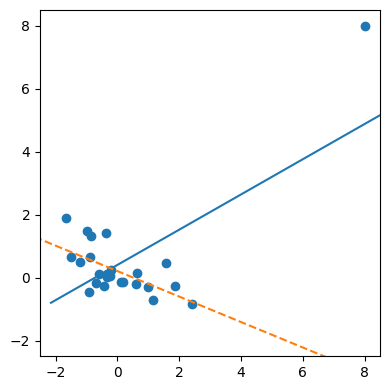

In [92]:
from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x,y)
slope, intercept, _, _, _ = linregress(x,y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8.5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()

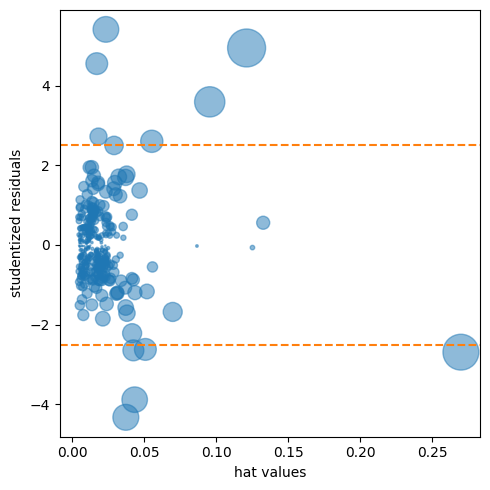

In [95]:
influence = OLSInfluence(result_98105)
fig, ax = plt.subplots(figsize=(5,5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, 
           influence.resid_studentized_internal,
           s=1000 * np.sqrt(influence.cooks_distance[0]),
           alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

plt.tight_layout()
plt.show()

In [98]:
mask = [dist < 0.08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], 
                  house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    "Original" : result_98105.params,
    "Influential removed": result_infl.params
})

,Original,Influential removed
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


## Heteroskedasticity, Non-Normality and Correlated Errors

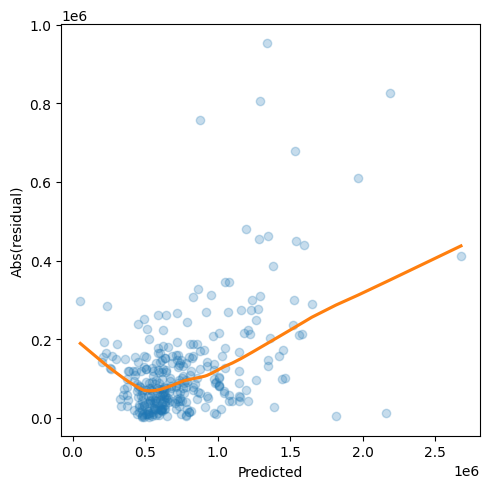

In [103]:
fig, ax, = plt.subplots(figsize=(5,5))
sns.regplot(x=result_98105.fittedvalues, 
            y=np.abs(result_98105.resid),
            scatter_kws={"alpha":0.25},
            line_kws={"color":"C1"},
            lowess=True, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Abs(residual)")

plt.tight_layout()
plt.show()

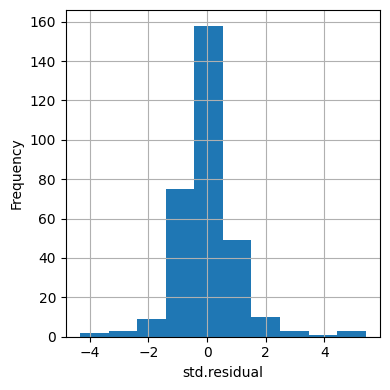

In [105]:
fig, ax = plt.subplots(figsize=(4,4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel("std.residual")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## Partial Residual Plots and Nonlinearity

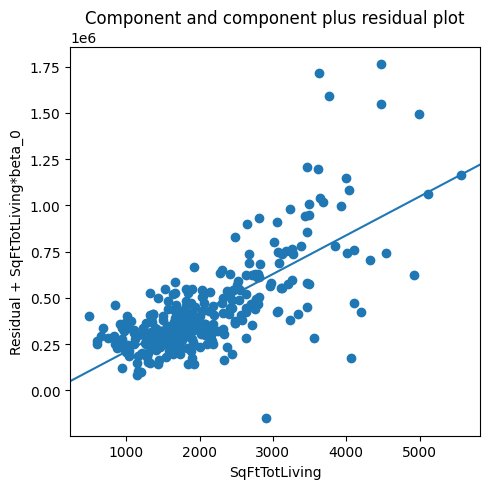

In [107]:
fig, ax = plt.subplots(figsize=(5,5))
fig = sm.graphics.plot_ccpr(result_98105, "SqFtTotLiving", ax=ax)

plt.tight_layout()
plt.show()

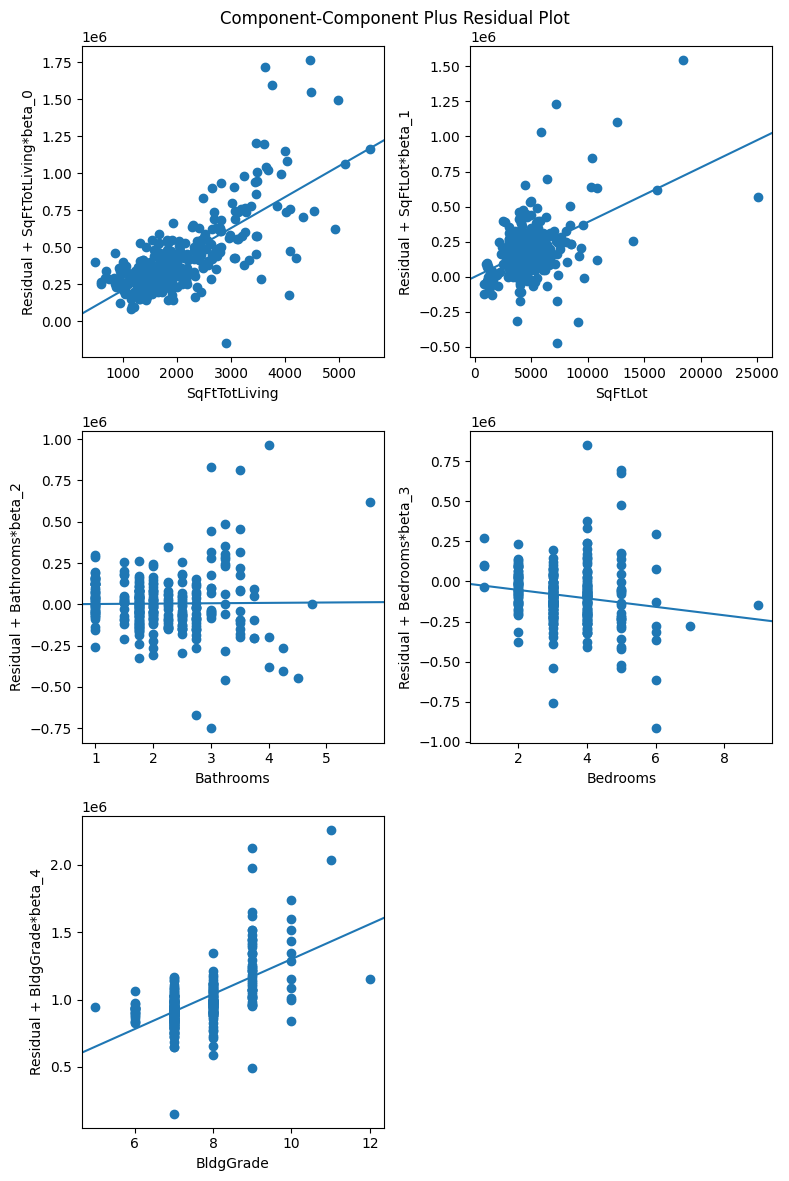

In [109]:
fig = plt.figure(figsize=(8,12))
fig = sm.graphics.plot_ccpr_grid(result_98105, fig=fig)

## Polynomial and Spline Regression

In [110]:
model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Fri, 24 Jan 2025   Prob (F-statistic):          9.95e-106
Time:                        09:36:29   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

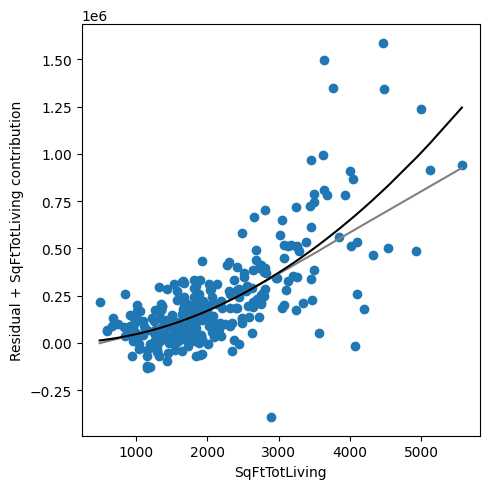

0.03879128168234777


In [111]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Residual + {feature} contribution')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])

## Splines

In [113]:
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Fri, 24 Jan 2025   Prob (F-statistic):          7.10e-104
Time:                        10:21:41   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


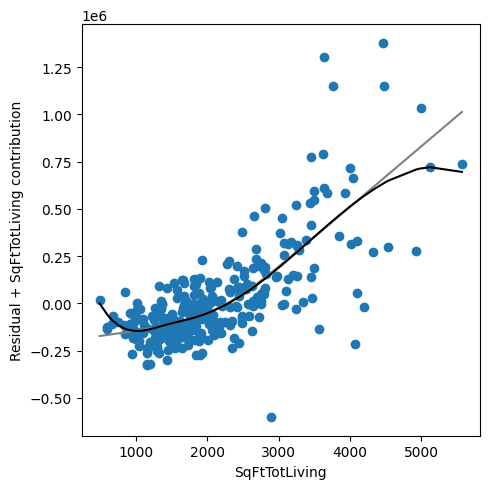

In [116]:
fig, ax = plt.subplots(figsize=(5,5))
partialResidualPlot(result_spline, 
                    house_98105,
                    "AdjSalePrice",
                    "SqFtTotLiving", ax)
plt.tight_layout()
plt.show()

## Generalized Additive Models

In [117]:
from statsmodels.gam.api import GLMGam, BSplines
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

x_spline = house_98105[predictors]
bs = BSplines(x_spline, 
              df=[10]+[3]*4, 
              degree=[3]+[2]*4)
#penalization weight
alpha = np.array([0]*5)

formula = ('AdjSalePrice ~ SqFtTotLiving + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')

gam_sm = GLMGam.from_formula(formula, 
                             data=house_98105,
                             smoother=bs,
                             alpha=alpha)
res_sm = gam_sm.fit()
print(res_sm.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:           AdjSalePrice   No. Observations:                  313
Model:                         GLMGam   Df Residuals:                      295
Model Family:                Gaussian   Df Model:                        17.00
Link Function:               Identity   Scale:                      2.7471e+10
Method:                         PIRLS   Log-Likelihood:                -4196.6
Date:                Fri, 24 Jan 2025   Deviance:                   8.1039e+12
Time:                        10:29:21   Pearson chi2:                 8.10e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9901
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -3.481e+05   1.18e+05  

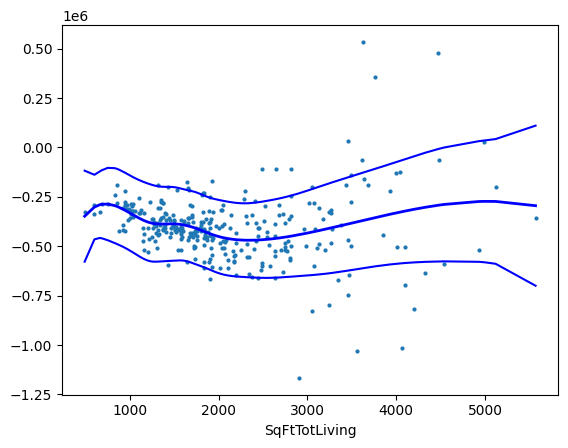

In [122]:
res_sm.plot_partial(0, cpr=True);

### Using pyGAM

In [123]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'
X = house_98105[predictors].values
y = house_98105[outcome]

gam = LinearGAM(s(0, n_splines=12) + l(1) + l(2) + l(3) + l(4))
gam.gridsearch(X,y)
print(gam.summary())

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6772
Link Function:                     IdentityLink Log Likelihood:                                 -7833.1159
Number of Samples:                          313 AIC:                                            15683.5863
                                                AICc:                                             15684.14
                                                GCV:                                      30838885095.1678
                                                Scale:                                    29480381715.8293
                                                Pseudo R-Squared:                                   0.8117
Feature Function                  Lam

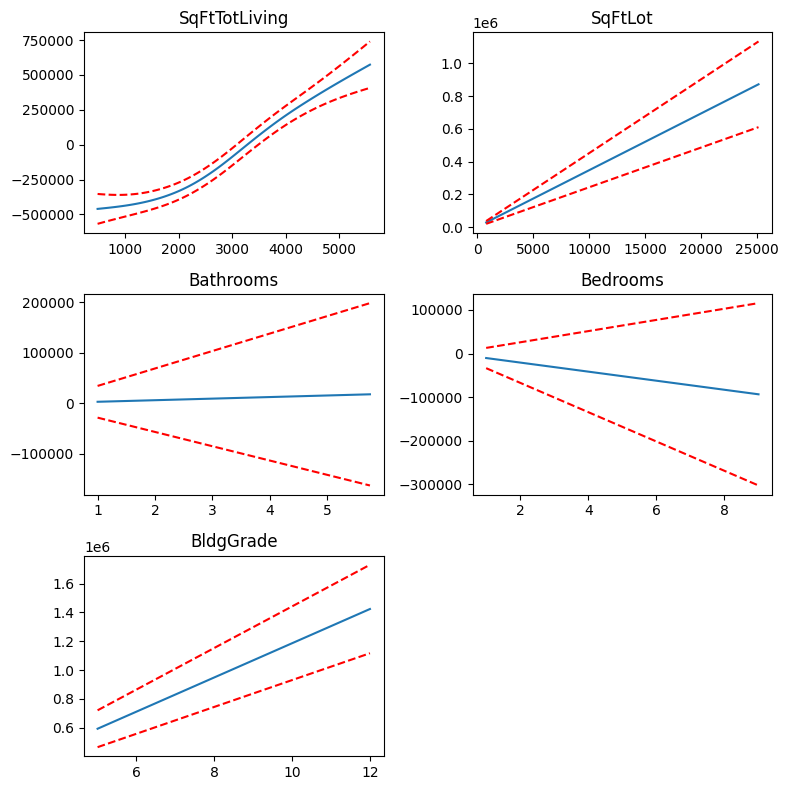

In [128]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=3)

titles = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
for i, title in enumerate(titles):
    ax = axes[i // 2, i % 2]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, 
                                             X=XX, 
                                             width=.95)[1], 
            c='r', ls='--')
    ax.set_title(titles[i]);
    
axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()

# Regularization
## Lasso

In [130]:
from sklearn.linear_model import (
    Lasso,
    LassoLars,
    LassoCV,
    LassoLarsCV)
from sklearn.preprocessing import StandardScaler



In [134]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

house = pd.read_csv('house_sales.csv', sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [135]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X["NewConstruction"]]
columns = X.columns
X = StandardScaler().fit_transform(X*1.0)
y=house[outcome]

house_lm = LinearRegression()
print(house_lm.fit(X,y))

LinearRegression()


In [136]:
house_lasso = Lasso(alpha=10)
print(house_lasso.fit(X,y))

Lasso(alpha=10)


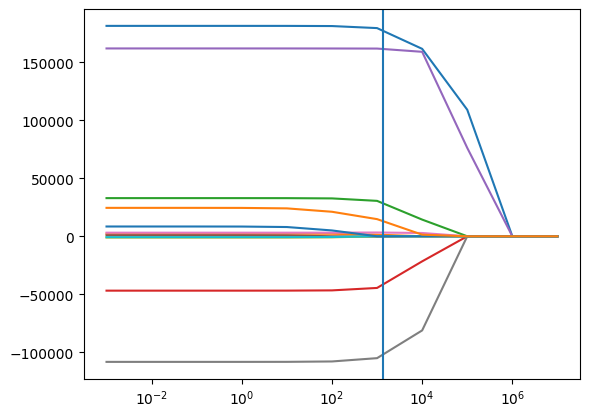

In [142]:
#MethodLars = LassoLars
#MethodLarsCV = LassoLarsCV
Method = Lasso
MethodCV = LassoCV

alpha_values=[]
results=[]
for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    model = Method(alpha=alpha)
    model.fit(X, y)
    alpha_values.append(alpha)
    results.append(model.coef_)
modelCV=MethodCV(cv=5)
modelCV.fit(X,y)
ax = pd.DataFrame(results, index=alpha_values, columns=columns).plot(logx=True, legend=False)
ax.axvline(modelCV.alpha_)
plt.show()

In [143]:
pd.DataFrame({
    'name': columns,
    'coef': modelCV.coef_, 
})

,name,coef
0,SqFtTotLiving,178995.820585
1,SqFtLot,1110.585770
2,Bathrooms,29843.352268
3,Bedrooms,-43790.256319
4,BldgGrade,161882.297251
5,NbrLivingUnits,-0.000000
6,SqFtFinBasement,3248.457098
7,YrBuilt,-104164.720862
8,YrRenovated,0.000000
9,NewConstruction,-0.000000


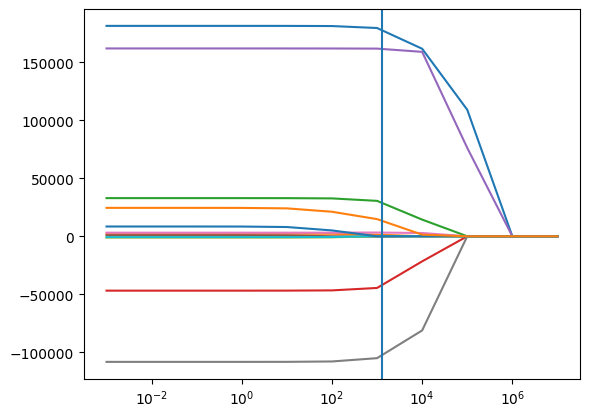

In [144]:
Method = LassoLars
MethodCV = LassoLarsCV
#Method = Lasso
#MethodCV = LassoCV

alpha_values=[]
results=[]
for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    model = Method(alpha=alpha)
    model.fit(X, y)
    alpha_values.append(alpha)
    results.append(model.coef_)
modelCV=MethodCV(cv=5)
modelCV.fit(X,y)
ax = pd.DataFrame(results, index=alpha_values, columns=columns).plot(logx=True, legend=False)
ax.axvline(modelCV.alpha_)
plt.show()

In [145]:
pd.DataFrame({
    'name': columns,
    'coef': modelCV.coef_, 
})

,name,coef
0,SqFtTotLiving,179103.474333
1,SqFtLot,1133.321370
2,Bathrooms,29889.740914
3,Bedrooms,-43863.814440
4,BldgGrade,161853.815093
5,NbrLivingUnits,0.000000
6,SqFtFinBasement,3233.412419
7,YrBuilt,-104243.497919
8,YrRenovated,0.000000
9,NewConstruction,0.000000
